Notebook for Assignment 7

In [1]:
if (!require(tidybayes)) {
    install.packages("tidybayes")
    library(tidybayes)
}

Loading required package: tidybayes

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘tidybayes’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘svUnit’, ‘arrayhelpers’




In [2]:
if (!require(brms)) {
    install.packages("brms")
    library(brms)
}

Loading required package: brms

Loading required package: Rcpp

Loading 'brms' package (version 2.22.5). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following objects are masked from ‘package:tidybayes’:

    dstudent_t, pstudent_t, qstudent_t, rstudent_t


The following object is masked from ‘package:stats’:

    ar




In [3]:
if (!require(metadat)) {
  install.packages("metadat")
  library(metadat)
}

Loading required package: metadat

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘metadat’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘mathjaxr’




In [4]:
if (!require(metadat)) {
  install.packages("metadat")
  library(metadat)
}

In [5]:
if(!require(cmdstanr)){
    install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
    library(cmdstanr)
}

Loading required package: cmdstanr

CmdStan path set to: /coursedata/cmdstan/cmdstan-2.35.0

This is cmdstanr version 0.8.0

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /coursedata/cmdstan/cmdstan-2.35.0

- CmdStan version: 2.35.0



In [6]:
cmdstan_installed <- function(){
  res <- try(out <- cmdstanr::cmdstan_path(), silent = TRUE)
  !inherits(res, "try-error")
}
if(!cmdstan_installed()){
    install_cmdstan()
}

In [7]:
hierarchical_sim <- function(group_pop_mean,
                             between_group_sd,
                             within_group_sd,
                             n_groups,
                             n_obs_per_group
                             ) {
  # Generate group means
  group_means <- rnorm(
    n = n_groups,
    mean = group_pop_mean,
    sd = between_group_sd
  )

  # Generate observations

  ## Create an empty vector for observations
  y <- numeric()
  ## Create a vector for the group identifier
  group <- rep(1:n_groups, each = n_obs_per_group)
  
  for (j in 1:n_groups) {
    ### Generate one group observations
    group_y <- rnorm(
      n = n_obs_per_group,
      mean = group_means[j],
      sd = within_group_sd
    )
    ### Append the group observations to the vector
    y <- c(y, group_y)
  }

  # Combine into a data frame
  data <- data.frame(
    group = factor(group),
    y = y
  )

  # Plot the data
  ggplot(data, aes(x = y, y = group)) +
    geom_point() +
    geom_vline(xintercept = group_pop_mean, linetype = "dashed")
}

In [8]:
if(!require(ggplot2)){
    install.packages("ggplot2")
    library(ggplot2)
}

Loading required package: ggplot2



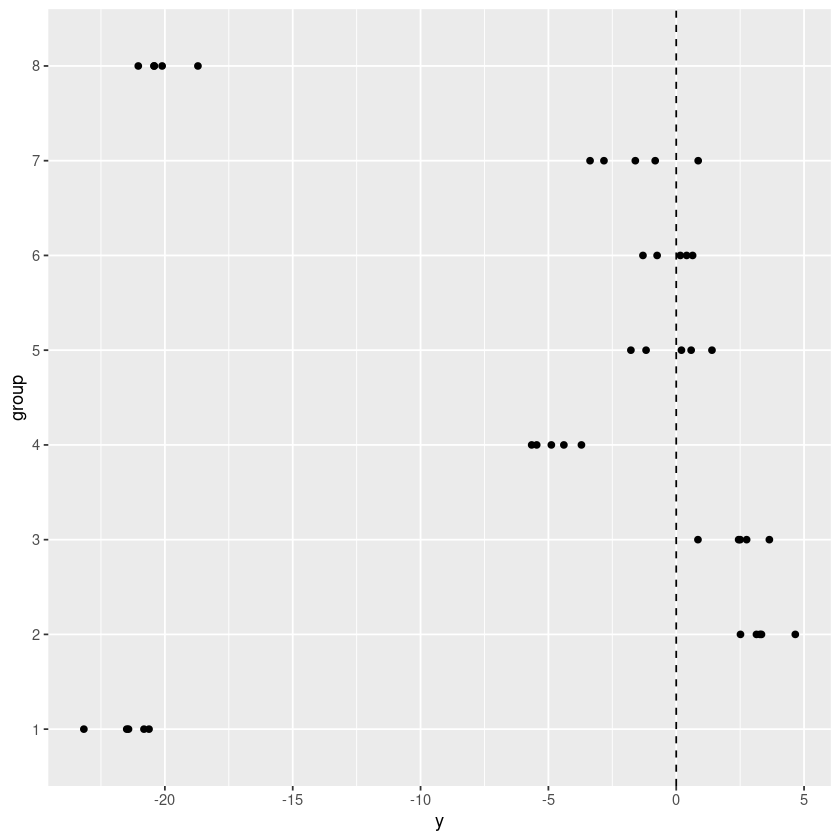

In [9]:
hierarchical_sim(
  group_pop_mean = 0,
  between_group_sd = 10,
  within_group_sd = 1,
  n_groups = 8,
  n_obs_per_group = 5
  )

3 Sleep deprivation

In [10]:
# Load library and data
library(brms)
data(sleepstudy, package = "lme4")

In [11]:
#Define the formula with the varying intercept per subject

sleepstudy_hierarchical_formula <- bf(
  Reaction ~ 1 + Days +(1 | Subject),
  family = "gaussian",
  center = FALSE
)

In [12]:
# Confirm the formula has been created
print(sleepstudy_hierarchical_formula)

Reaction ~ 1 + Days + (1 | Subject) 


In [13]:
# Generate default priors to see parameter names
default_prior(sleepstudy_hierarchical_formula, data = sleepstudy)

prior,class,coef,group,resp,dpar,nlpar,lb,ub,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,,default
,b,Days,,,,,,,default
,b,Intercept,,,,,,,default
"student_t(3, 0, 59.3)",sd,,,,,,0,,default
,sd,,Subject,,,,,,default
,sd,Intercept,Subject,,,,,,default
"student_t(3, 0, 59.3)",sigma,,,,,,0,,default


In [14]:
#Define the priors 

# Define the priors based on the specification provided
sleepstudy_hierarchical_priors <- c(
  prior(normal(250, 100), class = "b", coef ="Intercept"),  # population-level intercept
  prior(normal(0, 20), class = "b", coef = "Days"),  # effect of Days
  prior(normal(0, 100), class = "sd", group = "Subject"),  # varying intercept per subject
  prior(normal(0, 100), class = "sigma")  # residual standard deviation
)


In [15]:
# Confirm the priors have been created
print(sleepstudy_hierarchical_priors)

            prior class      coef   group resp dpar nlpar   lb   ub source
 normal(250, 100)     b Intercept                         <NA> <NA>   user
    normal(0, 20)     b      Days                         <NA> <NA>   user
   normal(0, 100)    sd           Subject                 <NA> <NA>   user
   normal(0, 100) sigma                                   <NA> <NA>   user


In [16]:
sleepstudy_hierarchical_model <- brm(
  formula = sleepstudy_hierarchical_formula,
  data = sleepstudy,
  prior = sleepstudy_hierarchical_priors,
  chains = 4,
  cores = 4,
  iter = 2000,
  seed = 123
)

Compiling Stan program...

Start sampling



In [17]:
# Summarize the model to view estimates
summary(sleepstudy_hierarchical_model)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: Reaction ~ 1 + Days + (1 | Subject) 
   Data: sleepstudy (Number of observations: 180) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~Subject (Number of levels: 18) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)    39.50      7.53    27.53    57.69 1.01      697     1245

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   251.71     10.68   230.80   273.20 1.01      469      845
Days         10.46      0.80     8.89    12.03 1.00     3587     2637

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    31.23      1.74    28.01    34.81 1.00     3374     3065

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, a

In [18]:
# Extract the posterior summary for only the population-level intercept
posterior_summary <- posterior_summary(sleepstudy_hierarchical_model)
population_level_intercept <- posterior_summary["b_Intercept", "Estimate"]

population_level_intercept

[1] 251.7056

In [19]:
posterior_summary <- posterior_summary(sleepstudy_hierarchical_model)
population_level_effect_days <- posterior_summary["b_Days", "Estimate"]

population_level_effect_days


[1] 10.46054

In [52]:
sleepstudy_pooled_formula <- bf(
  Reaction ~ 1 + Days,
  family = "gaussian",
  center = FALSE
)

#specify the priors:
(sleepstudy_pooled_priors <- c(
  prior(
    normal(250, 100),
    class = "b",
    coef = "Intercept"
  ),
  prior(
    normal(0, 20),
    class = "b",
    coef = "Days"
  ),
  prior(
    normal(0, 100),
    class = "sigma"
  )
))

#fit the model
sleepstudy_pooled_fit <- brm(
  formula = sleepstudy_pooled_formula,
  prior = sleepstudy_pooled_priors,
  data = sleepstudy
)



prior,class,coef,group,resp,dpar,nlpar,lb,ub,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
"normal(250, 100)",b,Intercept,,,,,NA,NA,user
"normal(0, 20)",b,Days,,,,,NA,NA,user
"normal(0, 100)",sigma,,,,,,NA,NA,user


Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.091 seconds (Warm-up)
Chain 1:                0.06 seconds (Sampling)
Chain 1:                0.151

In [53]:
#LOO with CV
sleepstudy_pooled_fit <- add_criterion(
  sleepstudy_pooled_fit,
  criterion = "loo"
)

loo(sleepstudy_pooled_fit)


Computed from 4000 by 180 log-likelihood matrix.

         Estimate   SE
elpd_loo   -953.4 10.5
p_loo         3.3  0.5
looic      1906.7 20.9
------
MCSE of elpd_loo is 0.0.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.3, 1.2]).

All Pareto k estimates are good (k < 0.7).
See help('pareto-k-diagnostic') for details.

Using 10 posterior draws for ppc type 'dens_overlay' by default.



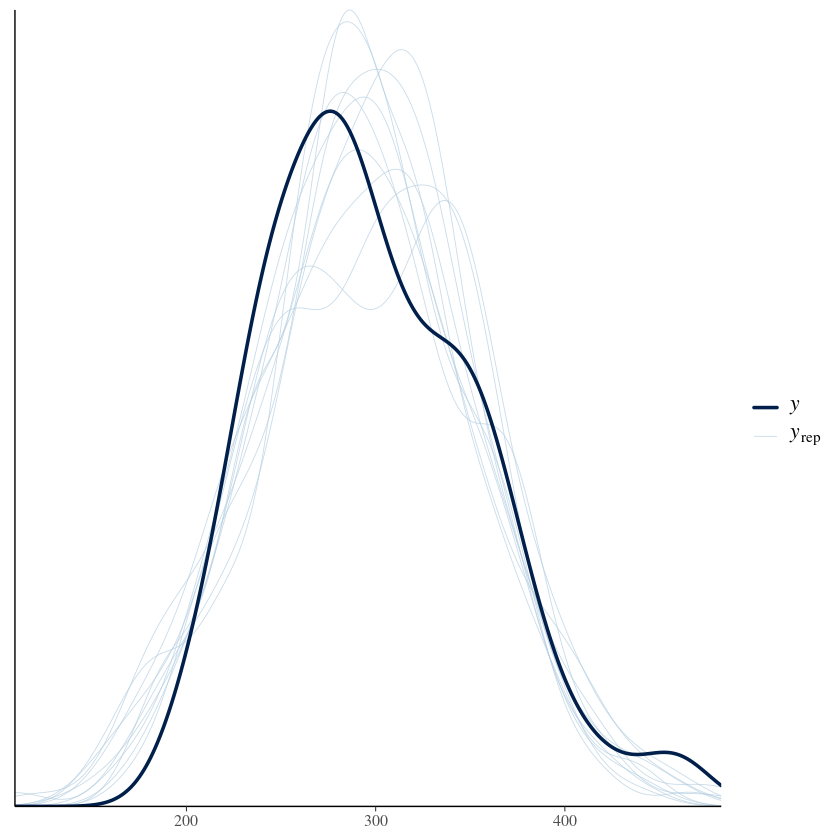

In [56]:
pp_check(sleepstudy_pooled_fit)

ERROR: Error: Variable 'Subject' could not be found in the data.


In [62]:
library(loo)

# Calculate LOO-CV for both models
loo_sleepstudy <- loo(sleepstudy_model)
loo_sleepstudy_pooled <- loo(sleepstudy_pooled_fit)

# Compare the models
loo_compare(loo_sleepstudy, loo_sleepstudy_pooled)

This is loo version 2.8.0.9000

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

Warning message:
“Found 3 observations with a pareto_k > 0.7 in model 'sleepstudy_model'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”


,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
sleepstudy_model,0.00000,0.00000,-861.3373,22.63988,34.414940,8.6223731,1722.675,45.27977
sleepstudy_pooled_fit,-92.03625,21.23372,-953.3736,10.46389,3.257801,0.4959992,1906.747,20.92778


a model with Subject-specific effects of Days in addition to the other terms.

In [20]:
# Define the formula with population-level and subject-specific effects
sleepstudy_model_formula <- bf(
  Reaction ~ 1 + Days + (1 + Days | Subject),  # Include both intercept and slope for each subject
  family = gaussian(),
  center = FALSE
)


In [21]:
# Define the priors
sleepstudy_model_priors <- c(
  prior(normal(0, 100), class = "b", coef="Intercept"),  # Population-level intercept
  prior(normal(0, 20), class = "b", coef = "Days"),  # Population-level effect of Days
  prior(normal(0, 100), class = "sd", group = "Subject", coef = "Intercept"),  # Varying intercept
  prior(normal(0, 20), class = "sd", group = "Subject", coef = "Days"),  # Varying slope
  #prior(normal(0, 100), class = "tau", coef = "alpha"),  # Prior for τα
  #prior(normal(0, 20), class = "tau", coef = "beta"),  # Prior for τβ
  prior(lkj(2), class = "cor")  # Correlation matrix prior
)

In [22]:
# Fit the model
sleepstudy_model <- brm(
  formula = sleepstudy_model_formula,
  data = sleepstudy,
  prior = sleepstudy_model_priors,
  chains = 4,
  cores = 4,
  iter = 2000,
  seed = 123
)


Compiling Stan program...

Start sampling



In [23]:
# Summarize the model to view estimates
summary(sleepstudy_model)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: Reaction ~ 1 + Days + (1 + Days | Subject) 
   Data: sleepstudy (Number of observations: 180) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~Subject (Number of levels: 18) 
                    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)          27.18      6.96    15.70    42.61 1.00     1726     2325
sd(Days)                6.49      1.44     4.18     9.73 1.00     1854     2834
cor(Intercept,Days)     0.09      0.27    -0.42     0.62 1.00     1362     2335

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   250.18      7.54   235.13   264.60 1.00     1286     1868
Days         10.39      1.69     7.03    13.62 1.00     1933     2676

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma   

Using all posterior draws for ppc type 'intervals_grouped' by default.



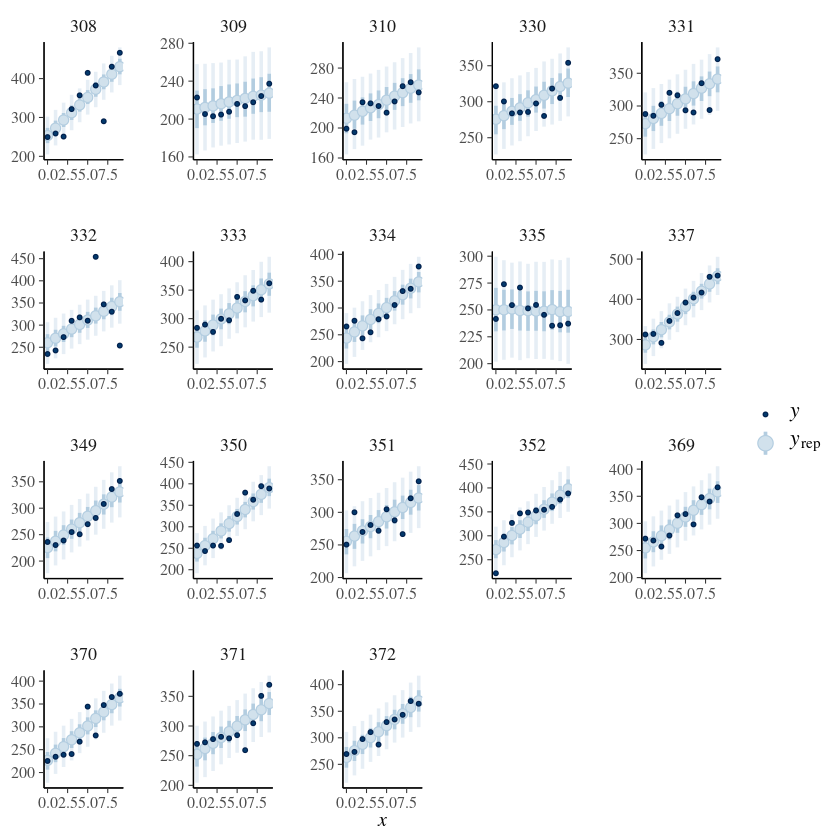

In [59]:
pp_check(sleepstudy_model, type = "intervals_grouped", x = "Days", group = "Subject")

In [61]:
#LOO with CV
sleepstudy_model_fit <- add_criterion(
  sleepstudy_model,
  criterion = "loo"
)

loo(sleepstudy_model)

Warning message:
“Found 3 observations with a pareto_k > 0.7 in model 'sleepstudy_model'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”
Warning message:
“Found 3 observations with a pareto_k > 0.7 in model 'sleepstudy_model'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”



Computed from 4000 by 180 log-likelihood matrix.

         Estimate   SE
elpd_loo   -861.3 22.6
p_loo        34.4  8.6
looic      1722.7 45.3
------
MCSE of elpd_loo is NA.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.5, 1.2]).

Pareto k diagnostic values:
                         Count Pct.    Min. ESS
(-Inf, 0.7]   (good)     177   98.3%   561     
   (0.7, 1]   (bad)        2    1.1%   <NA>    
   (1, Inf)   (very bad)   1    0.6%   <NA>    
See help('pareto-k-diagnostic') for details.

7. School calendar dataset

In [24]:
data(dat.konstantopoulos2011, package = "metadat")

In [25]:
schoolcalendar_data <- dat.konstantopoulos2011 |>
  dplyr::mutate(
    school = factor(school),
    district = factor(district),
    district_school = interaction(district, school, drop = TRUE, sep = "_")
  )

In [26]:
schoolcalendar_pooled_formula <- bf(
  formula = yi | se(sqrt(vi)) ~ 1,
  family = "gaussian"
)  

schoolcalendar_pooled_fit <- brm(
  formula = schoolcalendar_pooled_formula,
  data = schoolcalendar_data
)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.026 seconds (Warm-up)
Chain 1:                0.028 seconds (Sampling)
Chain 1:                0.05

In [27]:
# Summarize the model to view estimates
summary(schoolcalendar_pooled_fit)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: yi | se(sqrt(vi)) ~ 1 
   Data: schoolcalendar_data (Number of observations: 56) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.05      0.01     0.03     0.06 1.00     1587     1812

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.00      0.00     0.00     0.00   NA       NA       NA

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [28]:
new_school <- data.frame(
  school = factor(1),
  district = factor(1),
  district_school = factor("1_1"),
  vi = 0 # the expectation of the prediction is not affected by the sampling variance, so this can be any number
)
  

schoolcalendar_post_epred <- posterior_epred(
    schoolcalendar_pooled_fit,
    newdata = new_school,
    allow_new_levels = TRUE
  )

In [29]:
plot_school_posteriors <- function(fit, dataset) {
  tidybayes::add_predicted_draws(dataset, fit) |>
    ggplot(
      aes(
        x = .prediction,
        y = interaction(district, school, sep = ", ", lex.order = TRUE))) +
    tidybayes::stat_halfeye() +
    ylab("District, school") +
    xlab("Posterior effect")
}

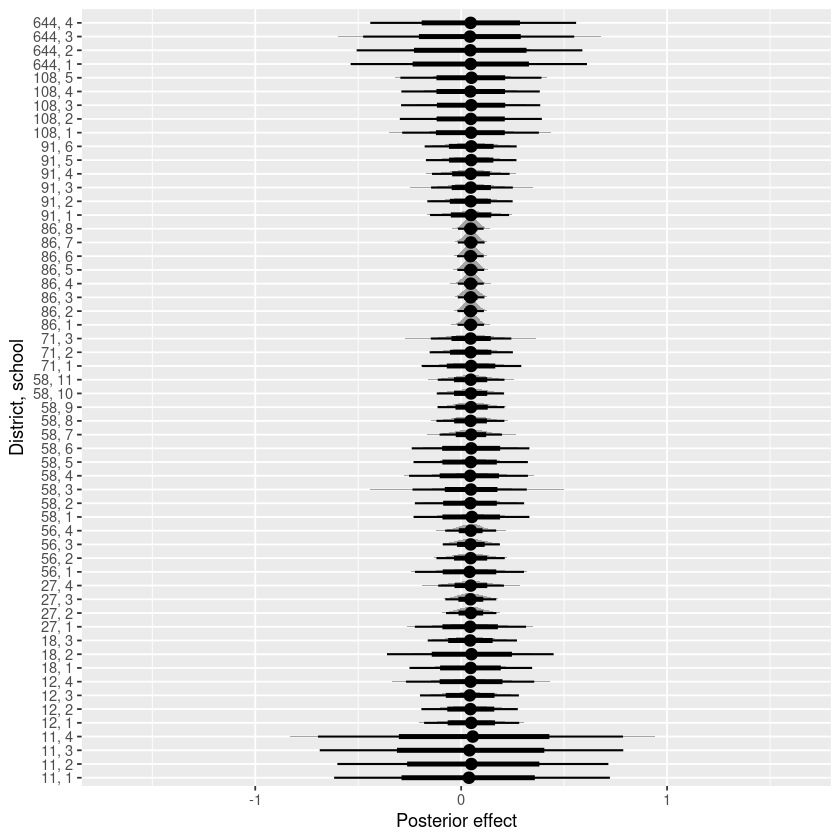

In [30]:
plot_school_posteriors(
  fit = schoolcalendar_pooled_fit,
  dataset = schoolcalendar_data
)

In [31]:
summary(schoolcalendar_post_epred)

       V1         
 Min.   :0.01647  
 1st Qu.:0.04053  
 Median :0.04655  
 Mean   :0.04667  
 3rd Qu.:0.05256  
 Max.   :0.07845  

In [32]:
schoolcalendar_pooled_formula <- bf(
  formula = yi | se(sqrt(vi)) ~ 1,
  family = "gaussian"
)  

schoolcalendar_pooled_fit <- brm(
  formula = schoolcalendar_pooled_formula,
  data = schoolcalendar_data
)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.03 seconds (Warm-up)
Chain 1:                0.026 seconds (Sampling)
Chain 1:                0.056

In [33]:
new_school2 <- data.frame(
  school = factor(9),
  district = factor(86),
  district_school = factor("9_86"),
  vi = 0 # the expectation of the prediction is not affected by the sampling variance, so this can be any number
)
  

schoolcalendar_post_epred <- posterior_epred(
    schoolcalendar_pooled_fit,
    newdata = new_school2,
    allow_new_levels = TRUE
  )

In [34]:
summary(schoolcalendar_post_epred)

       V1         
 Min.   :0.01430  
 1st Qu.:0.04062  
 Median :0.04689  
 Mean   :0.04687  
 3rd Qu.:0.05323  
 Max.   :0.07504  

In [35]:
# Create new data for prediction
new_school2 <- data.frame(
  school = factor(9),
  district = factor(86),
  district_school = factor("9_86"),
  vi = 0
)

# Get posterior predictions
posterior_predictions <- posterior_epred(
  schoolcalendar_pooled_fit,
  newdata = new_school2,
  allow_new_levels = TRUE
)

# Summarize the posterior predictions
summary(posterior_predictions)

       V1         
 Min.   :0.01430  
 1st Qu.:0.04062  
 Median :0.04689  
 Mean   :0.04687  
 3rd Qu.:0.05323  
 Max.   :0.07504  

In [36]:
schoolcalendar_pooled_formula <- bf(
  formula = yi | se(sqrt(vi)) ~ 1,
  family = "gaussian"
)  

schoolcalendar_pooled_fit <- brm(
  formula = schoolcalendar_pooled_formula,
  data = schoolcalendar_data
)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.029 seconds (Warm-up)
Chain 1:                0.035 seconds (Sampling)
Chain 1:                0.06

In [37]:
new_school3 <- data.frame(
  school = factor(1),
  district = factor(30),
  district_school = factor("1_30"),
  vi = 0 # the expectation of the prediction is not affected by the sampling variance, so this can be any number
)
  

schoolcalendar_post_epred <- posterior_epred(
    schoolcalendar_pooled_fit,
    newdata = new_school3,
    allow_new_levels = TRUE
  )

In [38]:
# Summarize the posterior predictions
summary(posterior_predictions)

       V1         
 Min.   :0.01430  
 1st Qu.:0.04062  
 Median :0.04689  
 Mean   :0.04687  
 3rd Qu.:0.05323  
 Max.   :0.07504  

Separate model:

In [39]:
data(dat.konstantopoulos2011, package = "metadat")

schoolcalendar_data <- dat.konstantopoulos2011 |>
  dplyr::mutate(
    school = factor(school),
    district = factor(district),
    district_school = interaction(district, school, drop = TRUE, sep = "_")
  )

schoolcalendar_separate_formula <- bf(
  formula = yi | se(sqrt(vi)) ~ 0 + district_school,
  family = "gaussian"
)  

schoolcalendar_separate_fit <- brm(
  formula = schoolcalendar_separate_formula,
  data = schoolcalendar_data
)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.195 seconds (Warm-up)
Chain 1:                0.129 seconds (Sampling)
Chain 1:                0.32

In [40]:
# Summarize the model to view estimates
summary(schoolcalendar_separate_fit)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: yi | se(sqrt(vi)) ~ 0 + district_school 
   Data: schoolcalendar_data (Number of observations: 56) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Regression Coefficients:
                     Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
district_school11_1     -0.19      0.34    -0.86     0.47 1.00     6732
district_school12_1      0.13      0.12    -0.11     0.36 1.00     6067
district_school18_1      0.45      0.15     0.15     0.75 1.00     6787
district_school27_1      0.16      0.14    -0.12     0.45 1.00     7157
district_school56_1      0.08      0.14    -0.20     0.36 1.00     5544
district_school58_1     -0.18      0.14    -0.46     0.09 1.00     6215
district_school71_1      0.30      0.12     0.07     0.53 1.00     6118
district_school86_1     -0.07      0.03    -0.13    -0.01 1.00     6974
district_school91_1      0.50      0.10     0.31 

In [41]:
new_school <- data.frame(
  district = factor(71),
  school = factor(3),
  district_school = factor("71_3"),
  vi = 0 # the expectation of the prediction is not affected by the sampling variance, so this can be any number
)
  

schoolcalendar_post_epred <- posterior_epred(
    schoolcalendar_separate_fit,
    newdata = new_school,
    allow_new_levels = TRUE
  )

In [42]:
# Summarize the posterior predictions
summary(schoolcalendar_post_epred)

       V1        
 Min.   :0.8256  
 1st Qu.:1.1236  
 Median :1.1904  
 Mean   :1.1903  
 3rd Qu.:1.2564  
 Max.   :1.5699  

In [43]:
new_school <- data.frame(
  district = factor(86),
  school = factor(7),
  district_school = factor("86_7"),
  vi = 0 # the expectation of the prediction is not affected by the sampling variance, so this can be any number
)
  

schoolcalendar_post_epred <- posterior_epred(
    schoolcalendar_separate_fit,
    newdata = new_school,
    allow_new_levels = TRUE
  )

# Summarize the posterior predictions
summary(schoolcalendar_post_epred)

       V1          
 Min.   :-0.11891  
 1st Qu.:-0.01043  
 Median : 0.01035  
 Mean   : 0.01053  
 3rd Qu.: 0.03140  
 Max.   : 0.11474  

Partially pooled model for schools.

In [44]:
data(dat.konstantopoulos2011, package = "metadat")

schoolcalendar_data <- dat.konstantopoulos2011 |>
  dplyr::mutate(
    school = factor(school),
    district = factor(district),
    district_school = interaction(district, school, drop = TRUE, sep = "_")
  )

schoolcalendar_PPS_formula <- bf(
  formula = yi | se(sqrt(vi)) ~ 1 + (1 | district_school),
  family = "gaussian"
)  

schoolcalendar_pps_fit <- brm(
  formula = schoolcalendar_PPS_formula,
  data = schoolcalendar_data
)

# Summarize the model to view estimates
summary(schoolcalendar_pps_fit)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.74 seconds (Warm-up)
Chain 1:                0.323 seconds (Sampling)
Chain 1:                1.063

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: yi | se(sqrt(vi)) ~ 1 + (1 | district_school) 
   Data: schoolcalendar_data (Number of observations: 56) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~district_school (Number of levels: 56) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.30      0.04     0.24     0.38 1.01      714     1054

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.13      0.04     0.04     0.22 1.02      332      547

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.00      0.00     0.00     0.00   NA       NA       NA

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction fac

In [45]:
new_school <- data.frame(
  district = factor(71),
  school = factor(3),
  district_school = factor("71_3"),
  vi = 0 # the expectation of the prediction is not affected by the sampling variance, so this can be any number
)
  

schoolcalendar_post_epred <- posterior_epred(
    schoolcalendar_pps_fit,
    newdata = new_school,
    allow_new_levels = TRUE
  )

# Summarize the posterior predictions
summary(schoolcalendar_post_epred)

       V1        
 Min.   :0.7286  
 1st Qu.:1.0163  
 Median :1.0837  
 Mean   :1.0820  
 3rd Qu.:1.1491  
 Max.   :1.4217  

In [46]:
new_school <- data.frame(
  district = factor(86),
  school = factor(7),
  district_school = factor("86_7"),
  vi = 0 # the expectation of the prediction is not affected by the sampling variance, so this can be any number
)
  

schoolcalendar_post_epred <- posterior_epred(
    schoolcalendar_pps_fit,
    newdata = new_school,
    allow_new_levels = TRUE
  )

# Summarize the posterior predictions
summary(schoolcalendar_post_epred)

       V1          
 Min.   :-0.09747  
 1st Qu.:-0.00965  
 Median : 0.01147  
 Mean   : 0.01144  
 3rd Qu.: 0.03265  
 Max.   : 0.11962  

In [47]:
new_school <- data.frame(
  district = factor(86),
  school = factor(9),
  district_school = factor("86_9"),
  vi = 0 # the expectation of the prediction is not affected by the sampling variance, so this can be any number
)
  

schoolcalendar_post_epred <- posterior_epred(
    schoolcalendar_pps_fit,
    newdata = new_school,
    allow_new_levels = TRUE
  )

# Summarize the posterior predictions
summary(schoolcalendar_post_epred)

       V1          
 Min.   :-0.69808  
 1st Qu.:-0.05050  
 Median : 0.05858  
 Mean   : 0.12630  
 3rd Qu.: 0.26891  
 Max.   : 1.27821  

In [48]:
new_school <- data.frame(
  district = factor(30),
  school = factor(1),
  district_school = factor("30_1"),
  vi = 0 # the expectation of the prediction is not affected by the sampling variance, so this can be any number
)
  

schoolcalendar_post_epred <- posterior_epred(
    schoolcalendar_pps_fit,
    newdata = new_school,
    allow_new_levels = TRUE
  )

# Summarize the posterior predictions
summary(schoolcalendar_post_epred)

       V1          
 Min.   :-0.69617  
 1st Qu.:-0.05611  
 Median : 0.05194  
 Mean   : 0.12680  
 3rd Qu.: 0.26437  
 Max.   : 1.29024  

Partially pooled model for schools in districts:

In [49]:
schoolcalendar_ppsd_formula <- bf(
  formula = yi | se(sqrt(vi)) ~ 1 + (1 | district_school) + (1 | district),
  family = "gaussian"
)  

schoolcalendar_ppsd_fit <- brm(
  formula = schoolcalendar_ppsd_formula,
  data = schoolcalendar_data
)

# Summarize the model to view estimates
summary(schoolcalendar_ppsd_fit)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.826 seconds (Warm-up)
Chain 1:                1.356 seconds (Sampling)
Chain 1:                3.18

Warning message:
“There were 1 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: yi | se(sqrt(vi)) ~ 1 + (1 | district_school) + (1 | district) 
   Data: schoolcalendar_data (Number of observations: 56) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~district (Number of levels: 11) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.29      0.09     0.15     0.51 1.01      966     1224

~district_school (Number of levels: 56) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.19      0.03     0.13     0.26 1.00      988     1638

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.20      0.10    -0.00     0.40 1.00      878     1245

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.00      0.00     0.

In [50]:
new_school <- data.frame(
  district = factor(86),
  school = factor(9),
  district_school = factor("86_9"),
  vi = 0 # the expectation of the prediction is not affected by the sampling variance, so this can be any number
)
  

schoolcalendar_post_epred <- posterior_epred(
    schoolcalendar_ppsd_fit,
    newdata = new_school,
    allow_new_levels = TRUE
  )

# Summarize the posterior predictions
summary(schoolcalendar_post_epred)

       V1          
 Min.   :-0.75442  
 1st Qu.:-0.12050  
 Median :-0.01573  
 Mean   :-0.01423  
 3rd Qu.: 0.09326  
 Max.   : 0.74244  

In [51]:
new_school <- data.frame(
  district = factor(30),
  school = factor(1),
  district_school = factor("30_1"),
  vi = 0 # the expectation of the prediction is not affected by the sampling variance, so this can be any number
)
  

schoolcalendar_post_epred <- posterior_epred(
    schoolcalendar_ppsd_fit,
    newdata = new_school,
    allow_new_levels = TRUE
  )

# Summarize the posterior predictions
summary(schoolcalendar_post_epred)

       V1          
 Min.   :-0.86904  
 1st Qu.:-0.02037  
 Median : 0.15620  
 Mean   : 0.19050  
 3rd Qu.: 0.37317  
 Max.   : 1.42784  